In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
plt.style.use("/Users/hkamdar/harsh")
from sklearn.metrics import r2_score
from matplotlib import colors
import umap

In [2]:
w = np.load("/Users/hkamdar/Downloads/mock_all_spectra_no_noise_resample_prior_large.npz")

In [3]:
labels = w['labels']
l = w['wavelength']
sp = w['spectra']

In [4]:
class VAE(nn.Module):
    def __init__(self, input_dim=7214, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def loss_function(recon_x, x, mu, logvar, beta=1):
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 7214), reduction='sum')

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return BCE + beta*KLD

In [6]:
noise = True
if noise:
    n = 0.0075*np.random.randn(sp.shape[0], sp.shape[1])
    sp += n
    
s = torch.Tensor(sp)
shuffled_idxs = np.random.choice(len(s), len(s), replace=False)
train = s[shuffled_idxs[0:10000]]
test = s[shuffled_idxs[10000:]]
train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)

In [7]:
model = VAE(hidden_dim=800, latent_dim=20).to(torch.device("cpu"))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for i in range(50):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(torch.device("cpu"))
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = model.loss_function(recon_batch, data, mu, logvar, beta=1)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()


    print('====> Epoch: {} Average loss: {:.4f}'.format(
          i, train_loss / len(train_loader.dataset)))

====> Epoch: 0 Average loss: 650.6769
====> Epoch: 1 Average loss: 415.5797
====> Epoch: 2 Average loss: 368.3498
====> Epoch: 3 Average loss: 333.3200
====> Epoch: 4 Average loss: 312.1704
====> Epoch: 5 Average loss: 299.0779
====> Epoch: 6 Average loss: 291.6703
====> Epoch: 7 Average loss: 284.5820
====> Epoch: 8 Average loss: 273.6544
====> Epoch: 9 Average loss: 271.7260
====> Epoch: 10 Average loss: 265.0027
====> Epoch: 11 Average loss: 257.7235
====> Epoch: 12 Average loss: 254.4409
====> Epoch: 13 Average loss: 253.3529
====> Epoch: 14 Average loss: 247.2828
====> Epoch: 15 Average loss: 245.1777
====> Epoch: 16 Average loss: 243.3514
====> Epoch: 17 Average loss: 240.8246
====> Epoch: 18 Average loss: 238.1619
====> Epoch: 19 Average loss: 240.2309
====> Epoch: 20 Average loss: 238.1463
====> Epoch: 21 Average loss: 235.5453
====> Epoch: 22 Average loss: 237.2704
====> Epoch: 23 Average loss: 231.5791
====> Epoch: 24 Average loss: 231.2689
====> Epoch: 25 Average loss: 231.2

(0.95, 1.02)

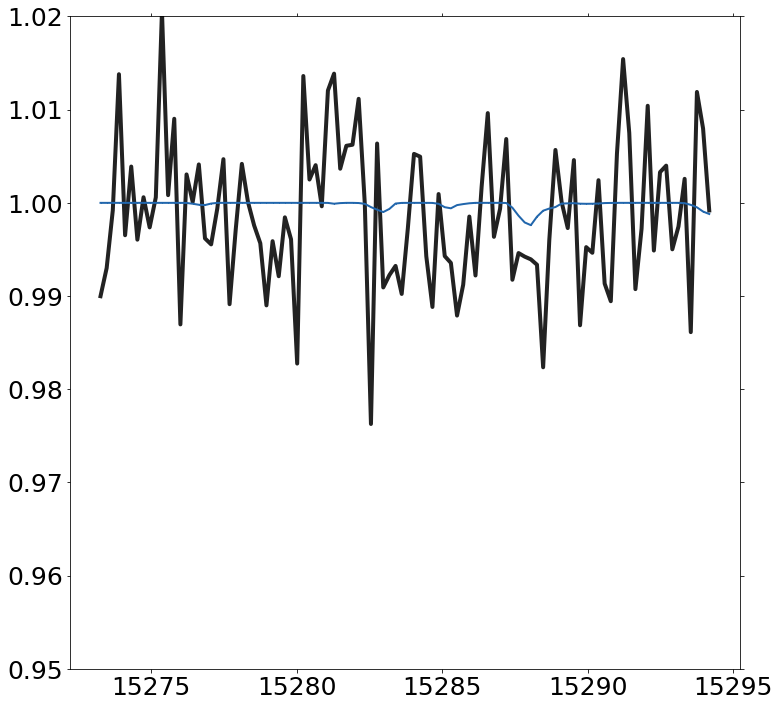

In [9]:
fig = plt.figure(figsize=(12,12))
plt.plot(l[500:600], test[2540][500:600])
plt.plot(l[500:600], model(test[2540])[0].detach().numpy()[0][500:600], linewidth=2)
plt.ylim([0.95, 1.02])

In [10]:
diffs = []
for i in range(len(test)):
    diffs.append(test[i].detach().numpy() - (model(test[i])[0].detach().numpy()[0]))
d = np.array(diffs)


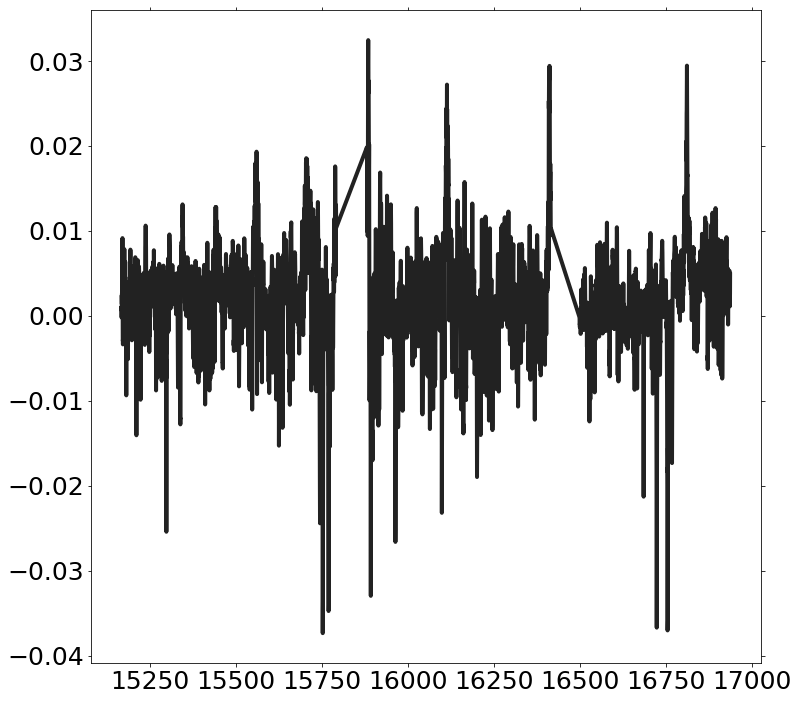

In [11]:
fig = plt.figure(figsize=(12,12))
plt.plot(l, np.mean(d,axis=0))

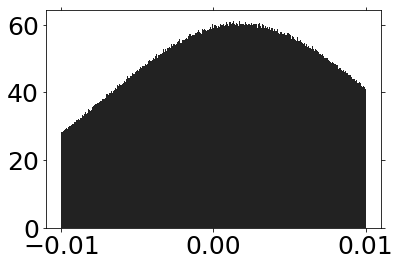

In [12]:
plt.hist(np.concatenate(d), bins=np.linspace(-0.01, 0.01, 1000), density=True)
plt.show()

In [13]:
r2s = []
for i in range(len(test)):
    r2s.append(r2_score(test[i].detach().numpy(), (model(test[i])[0].detach().numpy()[0])))

In [14]:
teff = labels[0,:]
logg = labels[1,:]

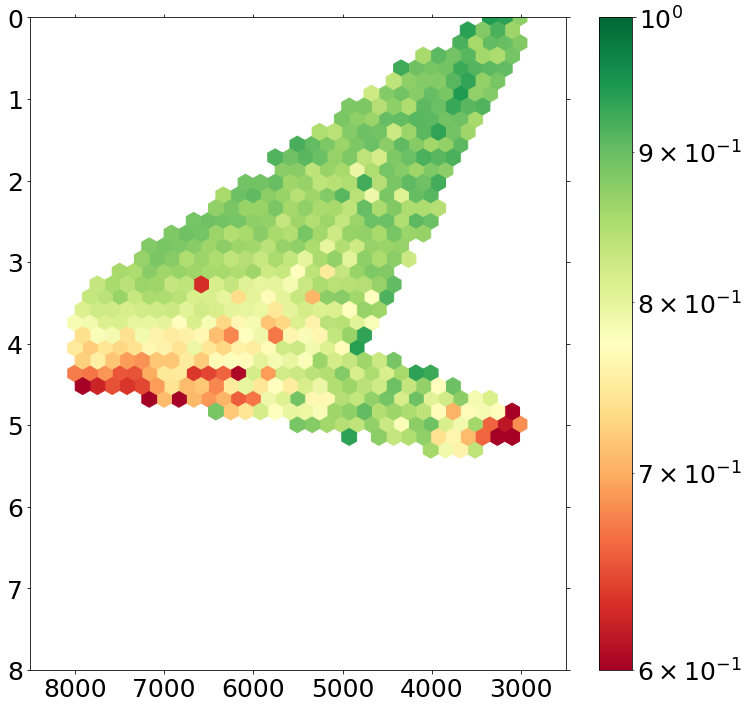

In [15]:
fig = plt.figure(figsize=(12,12))
plt.hexbin(teff[shuffled_idxs[10000:]], logg[shuffled_idxs[10000:]], gridsize=30, C=r2s, cmap=plt.cm.RdYlGn, norm=colors.LogNorm(), vmin=0.6, vmax=1.0)
plt.colorbar()
plt.xlim([8500, 2500])
plt.ylim([8, 0])
plt.show()

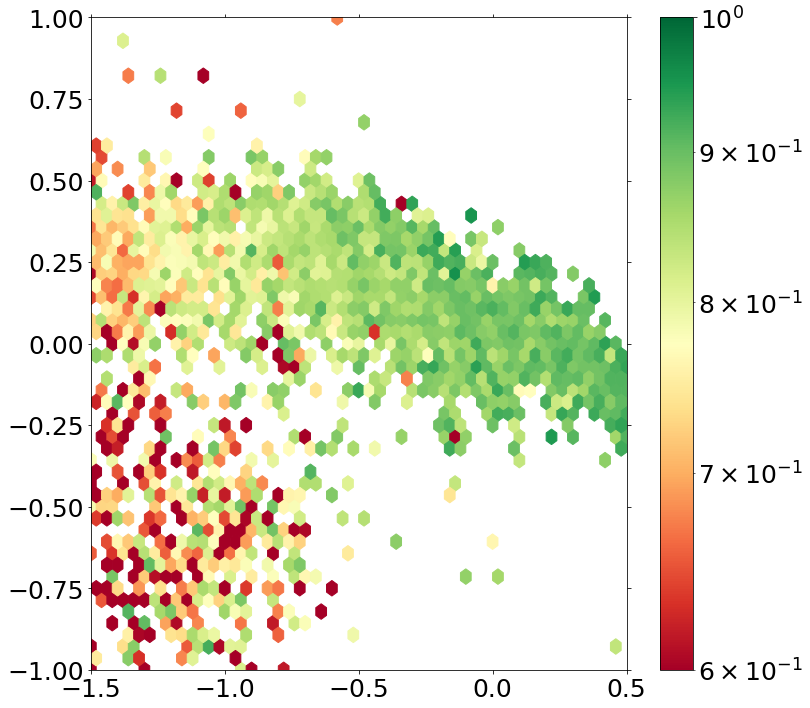

In [16]:
fig = plt.figure(figsize=(12,12))
plt.hexbin(labels[18,:][shuffled_idxs[10000:]], labels[7,:][shuffled_idxs[10000:]] - labels[18,:][shuffled_idxs[10000:]], gridsize=50, C=r2s, cmap=plt.cm.RdYlGn, norm=colors.LogNorm(), vmin=0.6, vmax=1.0, extent=[-1.5, 0.5, -1, 1])
plt.colorbar()
plt.xlim([-1.5, 0.5])
plt.ylim([-1, 1])
plt.show()

In [17]:
mu = (model(test)[1]).detach().numpy()
reducer = umap.UMAP()
embedding = reducer.fit_transform(mu)

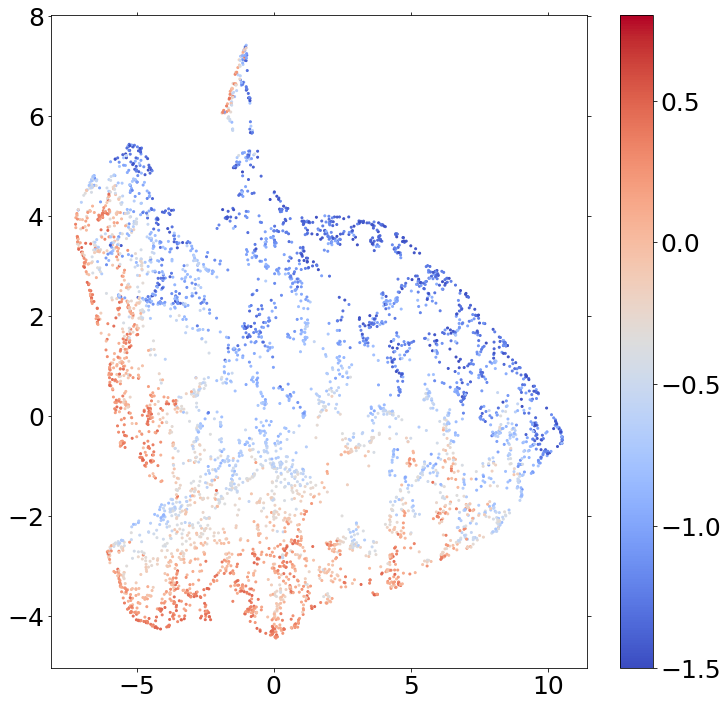

In [19]:
fig = plt.figure(figsize=(12,12))
plt.scatter(embedding[:,0], embedding[:,1], c=labels[18,:][shuffled_idxs[10000:]], cmap=plt.cm.coolwarm, vmin=-1.5, vmax=0.8)
plt.colorbar()